#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
file1 = 'data01_train.csv'
file2 = 'data01_test.csv'
file3 = 'features.csv'

In [ ]:
data = pd.read_csv(path + file1)
test = pd.read_csv(path + file2)
features = pd.read_csv(path + file3)

In [ ]:
# 불필요한 칼럼 삭제
data.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
data.shape

(5881, 562)

In [ ]:
#전체 데이터의 상위 5개 행 확인
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
#전체 데이터의 모든 변수 확인
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [ ]:
print(data['Activity'].unique())
data['is_dynamic'] = np.where(data['Activity'].isin(['STANDING', 'LAYING','SITTING']), 0, 1)

['STANDING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'
 'SITTING']


### (2) x, y 분리

In [ ]:
x = data.drop(['is_dynamic',  'Activity'], axis = 1)
y1 = data.loc[:, 'is_dynamic']
y2 = data.loc[:, 'Activity']

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

### (4) 데이터 분할
* train, val 분할

In [ ]:
x_train, x_val, y1_train, y1_val = train_test_split(x, y1, test_size = .2, random_state = 100)
_, _, y2_train, y2_val = train_test_split(x, y2, test_size = .2, random_state = 100)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.
    
    - 각 데이터를 torch.tensor( )로 변환합니다.
    - tensor로 변환한 데이터를 TensorDataset( )으로 데이터셋화 합니다.
    - 데이터셋을 배치 단위로 불러올 수 있게 DataLoader( )를 사용합니다.

In [ ]:
x_tr_tensor = torch.tensor(x_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)

In [ ]:
# is_dynamic : 정적 여부
# pd.Series -> numpy 데이터형 변환
y1_tr_numpy = y1_train.to_numpy()
y1_val_numpy = y1_val.to_numpy()

# numpy -> torch.tensor 데이터형 변환
y1_tr_tensor = torch.tensor(y1_tr_numpy, dtype=torch.long)
y1_val_tensor = torch.tensor(y1_val_numpy, dtype=torch.long)

In [ ]:
dataset_tr_dynamic = TensorDataset(x_tr_tensor, y1_tr_tensor)
dataset_val_dynamic = TensorDataset(x_val_tensor, y1_val_tensor)

In [ ]:
dataloader_tr_dynamic = DataLoader(dataset_tr_dynamic, batch_size=32)
dataloader_val_dynamic = DataLoader(dataset_val_dynamic, batch_size=32)

#### 1) 모델1

In [ ]:
n_features = x_train.shape[1]

In [ ]:
# 모델 구조 설계

class ModelOne(nn.Module) :
    def __init__(self, n_features) :
        super(ModelOne, self).__init__()

        self.fc1 = nn.Linear(n_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)

    def forward(self, x) :
        x = F.relu(self.fc1(x) )
        x = F.relu(self.fc2(x) )
        x = F.relu(self.fc3(x) )
        x = F.relu(self.fc4(x) )
        x = F.relu(self.fc5(x) )
        x = self.fc6(x)
        return x

In [ ]:
# 모델 생성 및 옵티마이저, 손실 함수 설정

model1_1 = ModelOne(n_features)
optimizer = Adam(model1_1.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# 모델 학습
history = {'loss': [], 'val_loss': []}

for epoch in range(50) :
    model1_1.train()
    train_loss = 0

    for x_batch, y_batch in dataloader_tr_dynamic :
        optimizer.zero_grad()
        output = model1_1(x_batch)
        output = output.view(-1)

        loss = criterion(output, y_batch.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(dataloader_tr_dynamic)

    # 모델 검증
    model1_1.eval()
    val_loss = 0
    with torch.no_grad() :
        for x_batch, y_batch in dataloader_val_dynamic :
            output = model1_1(x_batch)
            output = output.view(-1)

            loss = criterion(output, y_batch.float())
            val_loss += loss.item()
    avg_val_loss = val_loss / len(dataloader_val_dynamic)

    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)

    print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch 1 | Train Loss: 0.0867, Val Loss: 0.0058
Epoch 2 | Train Loss: 0.0044, Val Loss: 0.0053
Epoch 3 | Train Loss: 0.0029, Val Loss: 0.0051
Epoch 4 | Train Loss: 0.0024, Val Loss: 0.0045
Epoch 5 | Train Loss: 0.0016, Val Loss: 0.0065
Epoch 6 | Train Loss: 0.0020, Val Loss: 0.0049
Epoch 7 | Train Loss: 0.0012, Val Loss: 0.0037
Epoch 8 | Train Loss: 0.0008, Val Loss: 0.0093
Epoch 9 | Train Loss: 0.0000, Val Loss: 0.0056
Epoch 10 | Train Loss: 0.0000, Val Loss: 0.0057
Epoch 11 | Train Loss: 0.0000, Val Loss: 0.0058
Epoch 12 | Train Loss: 0.0000, Val Loss: 0.0059
Epoch 13 | Train Loss: 0.0000, Val Loss: 0.0060
Epoch 14 | Train Loss: 0.0000, Val Loss: 0.0060
Epoch 15 | Train Loss: 0.0000, Val Loss: 0.0061
Epoch 16 | Train Loss: 0.0000, Val Loss: 0.0062
Epoch 17 | Train Loss: 0.0000, Val Loss: 0.0063
Epoch 18 | Train Loss: 0.0000, Val Loss: 0.0067
Epoch 19 | Train Loss: 0.0000, Val Loss: 0.0075
Epoch 20 | Train Loss: 0.0000, Val Loss: 0.0080
Epoch 21 | Train Loss: 0.0000, Val Loss: 0.0084
E

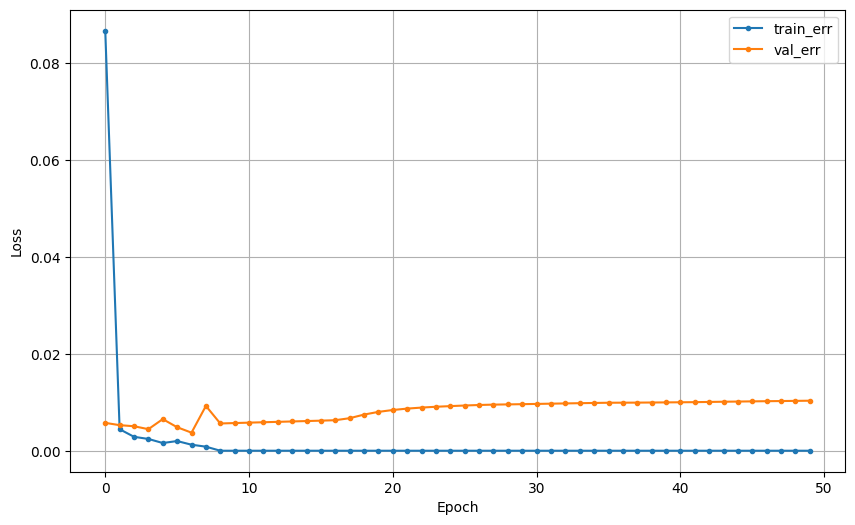

In [ ]:
dl_history_plot(history)

In [ ]:
# 예측 및 평가
model1_1.eval()
with torch.no_grad() :
    pred1_1 = model1_1(x_val_tensor)
    pred1_1 = torch.sigmoid(pred1_1).view(-1)
    pred1_1 = (pred1_1 >= 0.5).int()

print('Accuracy:', accuracy_score(y1_val, pred1_1.numpy()))
print('='*60)
print(confusion_matrix(y1_val, pred1_1.numpy()))
print('='*60)
print(classification_report(y1_val, pred1_1.numpy()) )

Accuracy: 0.9991503823279524
[[664   1]
 [  0 512]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       665
           1       1.00      1.00      1.00       512

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



#### 2) 모델2

In [ ]:
n_features = x_train.shape[1]

In [ ]:
# 모델 구조 설계
do_rate = 0.2

class ModelTwo(nn.Module) :
    def __init__(self, n_features) :
        super(ModelTwo, self).__init__()

        self.fc1 = nn.Linear(n_features, 512)
        self.dropout1 = nn.Dropout(do_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(do_rate)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(do_rate)
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(do_rate)
        self.fc5 = nn.Linear(64, 32)
        self.dropout5 = nn.Dropout(do_rate)
        self.fc6 = nn.Linear(32, 1)

    def forward(self, x) :
        x = F.relu(self.fc1(x) )
        x = self.dropout1(x)
        x = F.relu(self.fc2(x) )
        x = self.dropout2(x)
        x = F.relu(self.fc3(x) )
        x = self.dropout3(x)
        x = F.relu(self.fc4(x) )
        x = self.dropout4(x)
        x = F.relu(self.fc5(x) )
        x = self.dropout5(x)
        x = self.fc6(x)
        return x

In [ ]:
# 모델 생성 및 옵티마이저, 손실 함수 설정

model1_2 = ModelTwo(n_features)
optimizer = Adam(model1_2.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# 모델 학습
history = {'loss': [], 'val_loss': []}

for epoch in range(50) :
    model1_2.train()
    train_loss = 0

    for x_batch, y_batch in dataloader_tr_dynamic :
        optimizer.zero_grad()
        output = model1_2(x_batch)
        output = output.view(-1)

        loss = criterion(output, y_batch.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(dataloader_tr_dynamic)

    # 모델 검증
    model1_2.eval()
    val_loss = 0
    with torch.no_grad() :
        for x_batch, y_batch in dataloader_val_dynamic :
            output = model1_2(x_batch)
            output = output.view(-1)

            loss = criterion(output, y_batch.float())
            val_loss += loss.item()
    avg_val_loss = val_loss / len(dataloader_val_dynamic)

    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)

    print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch 1 | Train Loss: 0.0974, Val Loss: 0.0097
Epoch 2 | Train Loss: 0.0059, Val Loss: 0.0066
Epoch 3 | Train Loss: 0.0054, Val Loss: 0.0058
Epoch 4 | Train Loss: 0.0018, Val Loss: 0.0055
Epoch 5 | Train Loss: 0.0067, Val Loss: 0.0045
Epoch 6 | Train Loss: 0.0001, Val Loss: 0.0046
Epoch 7 | Train Loss: 0.0001, Val Loss: 0.0044
Epoch 8 | Train Loss: 0.0001, Val Loss: 0.0117
Epoch 9 | Train Loss: 0.0000, Val Loss: 0.0112
Epoch 10 | Train Loss: 0.0000, Val Loss: 0.0111
Epoch 11 | Train Loss: 0.0000, Val Loss: 0.0091
Epoch 12 | Train Loss: 0.0000, Val Loss: 0.0082
Epoch 13 | Train Loss: 0.0000, Val Loss: 0.0100
Epoch 14 | Train Loss: 0.0000, Val Loss: 0.0100
Epoch 15 | Train Loss: 0.0000, Val Loss: 0.0103
Epoch 16 | Train Loss: 0.0000, Val Loss: 0.0101
Epoch 17 | Train Loss: 0.0000, Val Loss: 0.0097
Epoch 18 | Train Loss: 0.0000, Val Loss: 0.0098
Epoch 19 | Train Loss: 0.0169, Val Loss: 0.0050
Epoch 20 | Train Loss: 0.0012, Val Loss: 0.0081
Epoch 21 | Train Loss: 0.0058, Val Loss: 0.0056
E

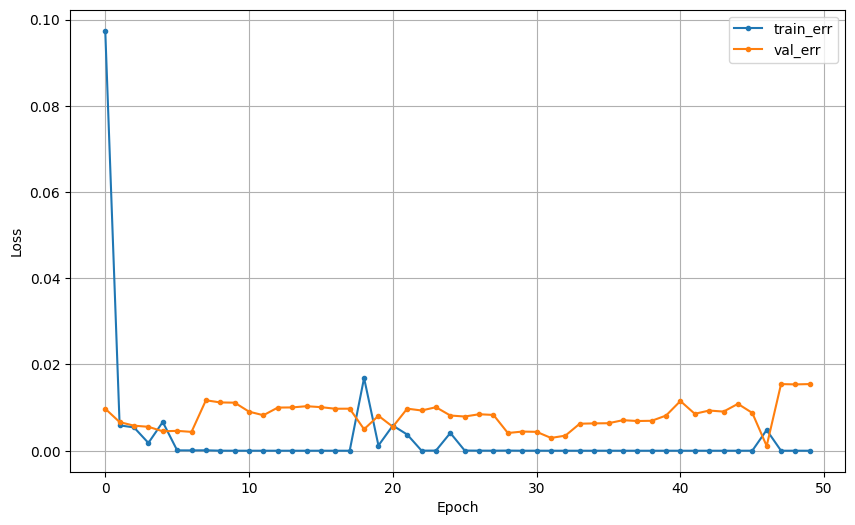

In [ ]:
dl_history_plot(history)

In [ ]:
# 예측 및 평가
model1_2.eval()
with torch.no_grad() :
    pred1_2 = model1_2(x_val_tensor)
    pred1_2 = torch.sigmoid(pred1_1).view(-1)
    pred1_2 = (pred1_2 >= 0.5).int()

print('Accuracy:', accuracy_score(y1_val, pred1_2.numpy()))
print('='*60)
print(confusion_matrix(y1_val, pred1_2.numpy()))
print('='*60)
print(classification_report(y1_val, pred1_2.numpy()) )

Accuracy: 0.43500424808836025
[[  0 665]
 [  0 512]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       665
           1       0.44      1.00      0.61       512

    accuracy                           0.44      1177
   macro avg       0.22      0.50      0.30      1177
weighted avg       0.19      0.44      0.26      1177



c:\Users\Datainsight-K\Desktop\Projects\proj_torch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Datainsight-K\Desktop\Projects\proj_torch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Datainsight-K\Desktop\Projects\proj_torch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

    - 각 데이터를 torch.tensor( )로 변환합니다.
    - tensor로 변환한 데이터를 TensorDataset( )으로 데이터셋화 합니다.
    - 데이터셋을 배치 단위로 불러올 수 있게 DataLoader( )를 사용합니다.

In [ ]:
x_train_0 = x_train[y1_train == 0]
y2_train_0 = y2_train[y1_train == 0]

x_val_0 = x_val[y1_val == 0]
y2_val_0 = y2_val[y1_val == 0]

In [ ]:
y2_train_0 = y2_train_0.map({'LAYING':0, 'STANDING':1, 'SITTING':2})
y2_val_0 = y2_val_0.map({'LAYING':0, 'STANDING':1, 'SITTING':2})

In [ ]:
# numpy -> torch.tensor 데이터형 변환
x_tr0_tensor = torch.tensor(x_train_0, dtype=torch.float32)
x_val0_tensor = torch.tensor(x_val_0, dtype=torch.float32)

In [ ]:
# pd.Series -> numpy 데이터형 변환
y2_tr0_numpy = y2_train_0.to_numpy()
y2_val0_numpy = y2_val_0.to_numpy()

# numpy -> torch.tensor 데이터형 변환
y2_tr0_tensor = torch.tensor(y2_tr0_numpy, dtype=torch.long)
y2_val0_tensor = torch.tensor(y2_val0_numpy, dtype=torch.long)

In [ ]:
dataset_tr0 = TensorDataset(x_tr0_tensor, y2_tr0_tensor)
dataset_val0 = TensorDataset(x_val0_tensor, y2_val0_tensor)

In [ ]:
dataloader_tr0 = DataLoader(dataset_tr0, batch_size=32)
dataloader_val0 = DataLoader(dataset_val0, batch_size=32)

In [ ]:
n_features = x_train.shape[1]

In [ ]:
# 모델 구조 설계
do_rate = 0.1

class ModelThree(nn.Module) :
    def __init__(self, n_features) :
        super(ModelThree, self).__init__()

        self.fc1 = nn.Linear(n_features, 512)
        self.dropout1 = nn.Dropout(do_rate)
        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(do_rate)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(do_rate)
        self.fc4 = nn.Linear(256, 256)
        self.dropout4 = nn.Dropout(do_rate)
        self.fc5 = nn.Linear(256, 128)
        self.dropout5 = nn.Dropout(do_rate)
        self.fc6 = nn.Linear(128, 128)
        self.dropout6 = nn.Dropout(do_rate)
        self.fc7 = nn.Linear(128, 64)
        self.dropout7 = nn.Dropout(do_rate)
        self.fc8 = nn.Linear(64, 64)
        self.dropout8 = nn.Dropout(do_rate)
        self.fc9 = nn.Linear(64, 32)
        self.dropout9 = nn.Dropout(do_rate)
        self.fc10 = nn.Linear(32, 32)
        self.dropout10 = nn.Dropout(do_rate)
        self.fc11 = nn.Linear(32, 3)

    def forward(self, x) :
        x = F.relu(self.fc1(x) )
        x = self.dropout1(x)
        x = F.relu(self.fc2(x) )
        x = self.dropout2(x)
        x = F.relu(self.fc3(x) )
        x = self.dropout3(x)
        x = F.relu(self.fc4(x) )
        x = self.dropout4(x)
        x = F.relu(self.fc5(x) )
        x = self.dropout5(x)
        x = F.relu(self.fc6(x) )
        x = self.dropout6(x)
        x = F.relu(self.fc7(x) )
        x = self.dropout7(x)
        x = F.relu(self.fc8(x) )
        x = self.dropout8(x)
        x = F.relu(self.fc9(x) )
        x = self.dropout9(x)
        x = F.relu(self.fc10(x) )
        x = self.dropout10(x)
        x = self.fc11(x)
        return x

In [ ]:
# 모델 생성 및 옵티마이저, 손실 함수 설정

model2_1 = ModelThree(n_features)
optimizer = Adam(model2_1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# 모델 학습
history = {'loss': [], 'val_loss': []}

for epoch in range(50) :
    model2_1.train()
    train_loss = 0

    for x_batch, y_batch in dataloader_tr0 :
        optimizer.zero_grad()
        output = model2_1(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(dataloader_tr0)

    # 모델 검증
    model2_1.eval()
    val_loss = 0
    with torch.no_grad() :
        for x_batch, y_batch in dataloader_val0 :
            output = model2_1(x_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(dataloader_val0)

    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)

    print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch 1 | Train Loss: 0.7757, Val Loss: 0.5669
Epoch 2 | Train Loss: 0.5010, Val Loss: 0.4740
Epoch 3 | Train Loss: 0.4751, Val Loss: 0.4606
Epoch 4 | Train Loss: 0.4697, Val Loss: 0.4518
Epoch 5 | Train Loss: 0.4701, Val Loss: 0.4786
Epoch 6 | Train Loss: 0.4570, Val Loss: 0.4689
Epoch 7 | Train Loss: 0.3975, Val Loss: 0.3533
Epoch 8 | Train Loss: 0.3214, Val Loss: 0.2472
Epoch 9 | Train Loss: 0.5369, Val Loss: 0.4731
Epoch 10 | Train Loss: 0.3468, Val Loss: 0.3391
Epoch 11 | Train Loss: 0.2591, Val Loss: 0.2204
Epoch 12 | Train Loss: 0.1948, Val Loss: 0.1914
Epoch 13 | Train Loss: 0.2000, Val Loss: 0.1556
Epoch 14 | Train Loss: 0.1700, Val Loss: 0.1798
Epoch 15 | Train Loss: 0.1881, Val Loss: 0.1604
Epoch 16 | Train Loss: 0.1619, Val Loss: 0.1096
Epoch 17 | Train Loss: 0.1415, Val Loss: 0.0867
Epoch 18 | Train Loss: 0.1247, Val Loss: 0.0933
Epoch 19 | Train Loss: 0.1033, Val Loss: 0.0853
Epoch 20 | Train Loss: 0.1016, Val Loss: 0.2881
Epoch 21 | Train Loss: 0.1669, Val Loss: 0.1057
E

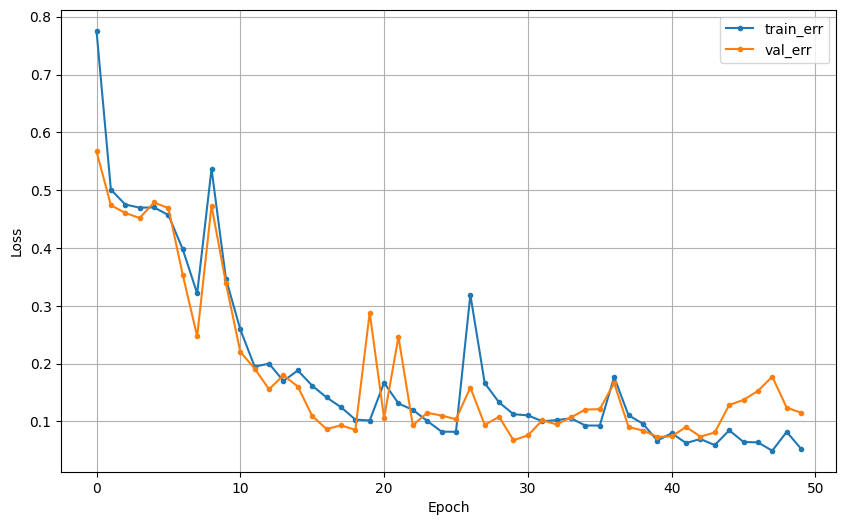

In [ ]:
# 학습곡선
dl_history_plot(history)

In [ ]:
# 예측 및 평가
model2_1.eval()
with torch.no_grad() :
    pred_logits = model2_1(x_val0_tensor)
    pred2_1 = torch.argmax(pred_logits, dim=1)

print('Accuracy:', accuracy_score(y2_val0_numpy, pred2_1.numpy()))
print('='*60)
print(confusion_matrix(y2_val0_numpy, pred2_1.numpy()))
print('='*60)
print(classification_report(y2_val0_numpy, pred2_1.numpy(), target_names=['LAYING', 'SITTING', 'STANDING']) )

Accuracy: 0.9744360902255639
[[227   0   0]
 [  0 209  10]
 [  0   7 212]]
              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00       227
     SITTING       0.97      0.95      0.96       219
    STANDING       0.95      0.97      0.96       219

    accuracy                           0.97       665
   macro avg       0.97      0.97      0.97       665
weighted avg       0.97      0.97      0.97       665



#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

    - 각 데이터를 torch.tensor( )로 변환합니다.
    - tensor로 변환한 데이터를 TensorDataset( )으로 데이터셋화 합니다.
    - 데이터셋을 배치 단위로 불러올 수 있게 DataLoader( )를 사용합니다.

In [ ]:
x_train_1 = x_train[y1_train == 1]
y2_train_1 = y2_train[y1_train == 1]

x_val_1 = x_val[y1_val == 1]
y2_val_1 = y2_val[y1_val == 1]

In [ ]:
y2_train_1 = y2_train_1.map({'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2})
y2_val_1 = y2_val_1.map({'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2})

In [ ]:
# numpy -> torch.tensor 데이터형 변환
x_tr1_tensor = torch.tensor(x_train_1, dtype=torch.float32)
x_val1_tensor = torch.tensor(x_val_1, dtype=torch.float32)

In [ ]:
# pd.Series -> numpy 데이터형 변환
y2_tr1_numpy = y2_train_1.to_numpy()
y2_val1_numpy = y2_val_1.to_numpy()

# numpy -> torch.tensor 데이터형 변환
y2_tr1_tensor = torch.tensor(y2_tr1_numpy, dtype=torch.long)
y2_val1_tensor = torch.tensor(y2_val1_numpy, dtype=torch.long)

In [ ]:
dataset_tr1 = TensorDataset(x_tr1_tensor, y2_tr1_tensor)
dataset_val1 = TensorDataset(x_val1_tensor, y2_val1_tensor)

In [ ]:
dataloader_tr1 = DataLoader(dataset_tr1, batch_size=32)
dataloader_val1 = DataLoader(dataset_val1, batch_size=32)

In [ ]:
n_features = x_train.shape[1]

In [ ]:
# 모델 생성 및 옵티마이저, 손실 함수 설정

model2_2 = ModelThree(n_features)
optimizer = Adam(model2_2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# 모델 학습
history = {'loss': [], 'val_loss': []}

for epoch in range(50) :
    model2_2.train()
    train_loss = 0

    for x_batch, y_batch in dataloader_tr1 :
        optimizer.zero_grad()
        output = model2_2(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(dataloader_tr1)

    # 모델 검증
    model2_2.eval()
    val_loss = 0
    with torch.no_grad() :
        for x_batch, y_batch in dataloader_val1 :
            output = model2_2(x_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(dataloader_val1)

    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)

    print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch 1 | Train Loss: 1.0501, Val Loss: 0.8698
Epoch 2 | Train Loss: 0.7422, Val Loss: 0.8036
Epoch 3 | Train Loss: 0.5769, Val Loss: 0.6699
Epoch 4 | Train Loss: 0.4197, Val Loss: 0.4015
Epoch 5 | Train Loss: 0.6728, Val Loss: 0.3858
Epoch 6 | Train Loss: 0.4110, Val Loss: 0.3106
Epoch 7 | Train Loss: 0.3293, Val Loss: 0.3241
Epoch 8 | Train Loss: 0.2027, Val Loss: 0.1762
Epoch 9 | Train Loss: 0.1452, Val Loss: 0.1630
Epoch 10 | Train Loss: 0.0899, Val Loss: 0.2148
Epoch 11 | Train Loss: 0.1145, Val Loss: 0.2700
Epoch 12 | Train Loss: 0.1161, Val Loss: 0.1496
Epoch 13 | Train Loss: 0.1221, Val Loss: 0.0992
Epoch 14 | Train Loss: 0.1058, Val Loss: 0.2946
Epoch 15 | Train Loss: 0.1093, Val Loss: 0.1173
Epoch 16 | Train Loss: 0.0886, Val Loss: 0.0480
Epoch 17 | Train Loss: 0.0669, Val Loss: 0.0405
Epoch 18 | Train Loss: 0.0444, Val Loss: 0.0419
Epoch 19 | Train Loss: 0.0273, Val Loss: 0.1032
Epoch 20 | Train Loss: 0.0477, Val Loss: 0.0317
Epoch 21 | Train Loss: 0.0583, Val Loss: 0.0551
E

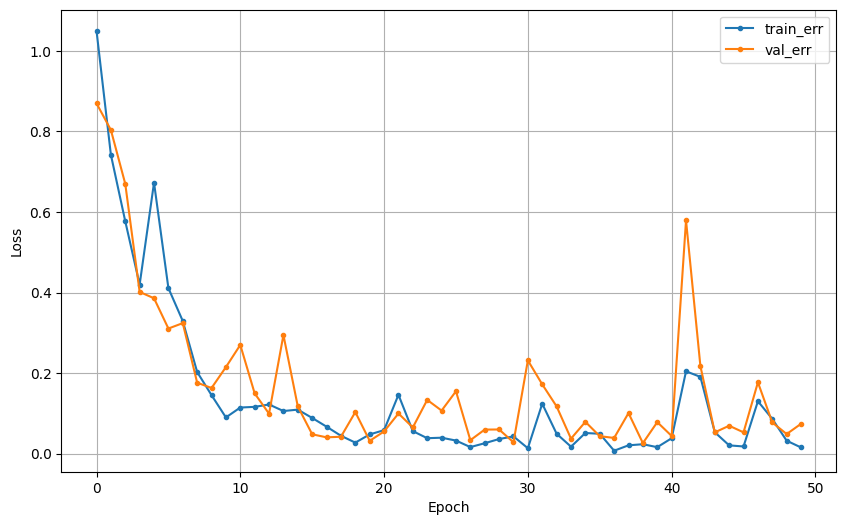

In [ ]:
# 학습곡선
dl_history_plot(history)

In [ ]:
# 예측 및 평가
model2_2.eval()
with torch.no_grad() :
    pred_logits = model2_2(x_val1_tensor)
    pred2_2 = torch.argmax(pred_logits, dim=1)

print('Accuracy:', accuracy_score(y2_val1_numpy, pred2_2.numpy()))
print('='*60)
print(confusion_matrix(y2_val1_numpy, pred2_2.numpy()))
print('='*60)
print(classification_report(y2_val1_numpy, pred2_2.numpy(), target_names=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']) )

Accuracy: 0.984375
[[197   0   1]
 [  3 168   4]
 [  0   0 139]]
                    precision    recall  f1-score   support

           WALKING       0.98      0.99      0.99       198
  WALKING_UPSTAIRS       1.00      0.96      0.98       175
WALKING_DOWNSTAIRS       0.97      1.00      0.98       139

          accuracy                           0.98       512
         macro avg       0.98      0.98      0.98       512
      weighted avg       0.98      0.98      0.98       512



### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
def model_comb(model1, model2_1, model2_2, new_data, scaler):

    # 1. 전처리 -----------------------------------

    ## 1) 스케일링
    col_name = list(new_data)[:-1]
    print(col_name)
    new_data.loc[:,col_name] = scaler.transform(new_data.loc[:,col_name])

    ## 2) 입력값 만들기
    new_x = new_data.drop(['Activity'], axis=1)
    new_x = torch.tensor(new_x.values, dtype=torch.float32)


    # 2.예측 -----------------------------------

    ## 1) 단계1 모델로 0,1 구분
    model1_1.eval()
    with torch.no_grad() :
        pred1 = model1_1(new_x)
        pred1 = torch.sigmoid(pred1).view(-1)
        pred1 = (pred1 >= 0.5).int()
    new_data['pred1'] = pred1


    ## 2) 단계1의 결과로 데이터 나누기
    new_x_0 = new_data.loc[new_data['pred1'] == 0]
    new_x_1 = new_data.loc[new_data['pred1'] == 1]
    x_0 = new_x_0.drop(['Activity','pred1'], axis = 1)
    x_1 = new_x_1.drop(['Activity','pred1'], axis = 1)
    x_0 = torch.tensor(x_0.values, dtype=torch.float32)
    x_1 = torch.tensor(x_1.values, dtype=torch.float32)


    ## 3) 단계2 모델로 예측.
    model2_1.eval()
    with torch.no_grad() :
        pred2_1 = model2_1(x_0)
        pred2_1 = torch.argmax(pred2_1, dim=1)

    model2_2.eval()
    with torch.no_grad() :
        pred2_2 = model2_2(x_1)
        pred2_2 = torch.argmax(pred2_2, dim=1)


    ## 4) 예측 결과를 원래 값으로 변환
    new_x_0['pred2'] = pred2_1
    new_x_0['pred2'] = new_x_0['pred2'].map({0:'LAYING', 1:'STANDING', 2:'SITTING'})

    new_x_1['pred2'] = pred2_2
    new_x_1['pred2'] = new_x_1['pred2'].map({0:'WALKING', 1:'WALKING_UPSTAIRS', 2:'WALKING_DOWNSTAIRS'})

    ## 5) 하나로 합치기
    result = pd.concat([new_x_0, new_x_1], axis = 0)

    # 3.최종 성능평가 -----------------------------------
    print('accuracy :',accuracy_score(result['pred2'], result['Activity']))
    print('='*60)
    print(confusion_matrix(result['pred2'], result['Activity']))
    print('='*60)
    print(classification_report(result['pred2'], result['Activity']))

#### 2) test 셋으로 예측하고 평가하기

In [ ]:
test = pd.read_csv(path + file2)
test.drop('subject', axis=1, inplace=True)
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


* 성능 평가

In [ ]:
model_comb(model1_1, model2_1, model2_2, test, scaler)

['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-min()-Z', 'tBodyAcc-sma()', 'tBodyAcc-energy()-X', 'tBodyAcc-energy()-Y', 'tBodyAcc-energy()-Z', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tBodyAcc-iqr()-Z', 'tBodyAcc-entropy()-X', 'tBodyAcc-entropy()-Y', 'tBodyAcc-entropy()-Z', 'tBodyAcc-arCoeff()-X,1', 'tBodyAcc-arCoeff()-X,2', 'tBodyAcc-arCoeff()-X,3', 'tBodyAcc-arCoeff()-X,4', 'tBodyAcc-arCoeff()-Y,1', 'tBodyAcc-arCoeff()-Y,2', 'tBodyAcc-arCoeff()-Y,3', 'tBodyAcc-arCoeff()-Y,4', 'tBodyAcc-arCoeff()-Z,1', 'tBodyAcc-arCoeff()-Z,2', 'tBodyAcc-arCoeff()-Z,3', 'tBodyAcc-arCoeff()-Z,4', 'tBodyAcc-correlation()-X,Y', 'tBodyAcc-correlation()-X,Z', 'tBodyAcc-correlation()-Y,Z', 'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-mean()-Z', 'tG

C:\Users\Datainsight-K\AppData\Local\Temp\ipykernel_10256\1789246493.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_x_0['pred2'] = pred2_1
C:\Users\Datainsight-K\AppData\Local\Temp\ipykernel_10256\1789246493.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_x_0['pred2'] = new_x_0['pred2'].map({0:'LAYING', 1:'STANDING', 2:'SITTING'})
C:\Users\Datainsight-K\AppData\Local\Temp\ipykernel_10256\1789246493.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat